# Data Programming cw 2 

## contents
- Introduction
- Aims and objectives
- Data acquisition
- Saving the dataset
- Data screening and cleaning
- High level look at the data and descriptive statistics
- Analysis
- Results
- Conclusion and discussion

## Introduction
This is a data analysis of the academic journal frontiers. The analysis of the journal metadata in the previous coursework indicated that more insights are likely to be obtained from looking at specific journals and the articles they contain. 

## Aims and Objectives
1. There is a common hypothesis in the field of neurosceince that there is a growing body of experimental results and a lack of theoretical work to help interpret and consolidate these experimental findings. This hypothesis can be tested on the relevant neuroscience journals published by frontiers.

2. It is common for the brain to be described as a complex system. Complex systems do not have an agreed upon definition but there does seem to be a general concensus amoung scientisits concered with them that they tend to have charachteristic properties. One such property is emergence, the idea that the whole is more than the sum of its parts, which is a difficulty problem to address with traditional reductionist methods. Therefore i would like to see how often this issue is cited in the literature and possibly analyse the sentiment towards it. My Hypothesis would be that there is likley a neutral or negative sentiment indicating a lack of drive to approach the problem and using it to explain away eroneuos results in experimental data etc.

3. Possibly doing a deeper dive on articles that match our criteria of interest. Such as, a sentiment analysis on the top original research articles compared to the hypothesis and theory articles.

# TODO
#### Basic
- Add screening and cleaning data code.
- mention creative commons licnece
- handel 404 error codes
- show evidence of data validation
1. descriptive statistics    
2. extract the most cited papers and their corresponding article type.
#### Most common words finder 
1. extracting most common words in article titles.
    - Another representation can be count the number of times each word appears in a document. The most popular approach is           using the Term Frequency-Inverse Document Frequency (TF-IDF) technique.
    - from this article https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958
    - from the same article "To get the frequency distribution of the words in the text, we can utilize the nltk.FreqDist()"
#### Take a closer look at the hypothesis and theory articles.
1. opening articles and retreiving the text for analysis.
    - How many of the articles mention complexity, emergence, self organisation etc
2. analysing and comparing article text.
    - e.g article text similarity
    - Article sentiment.

Imports we will need

In [117]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import FreqDist 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

## Data acquisition
The exploratory analysis indicated more data on specific journals would likely yeild more insights and so we will begin by collecting article data from all of the neuroscience journals identified in our exploratory analysis.

In [ ]:
aging = "https://www.frontiersin.org/journals/aging-neuroscience/articles"
behavioural = "https://www.frontiersin.org/journals/behavioral-neuroscience/articles"
cellular = "https://www.frontiersin.org/journals/cellular-neuroscience/articles"
computational = "https://www.frontiersin.org/journals/computational-neuroscience/articles"
evolutionary = "https://www.frontiersin.org/journals/evolutionary-neuroscience/articles"
human = "https://www.frontiersin.org/journals/human-neuroscience/articles"
integrative = "https://www.frontiersin.org/journals/integrative-neuroscience/articles"
molecular = "https://www.frontiersin.org/journals/molecular-neuroscience/articles"
neuroanatomy = "https://www.frontiersin.org/journals/neuroanatomy/articles"
neuroenergetics = "https://www.frontiersin.org/journals/neuroenergetics/articles"
neuroengineering = "https://www.frontiersin.org/journals/neuroengineering/articles"
neuroergonomics = "https://www.frontiersin.org/journals/neuroergonomics/articles"
neuroimaging = "https://www.frontiersin.org/journals/neuroimaging/articles"
neuroinformatics = "https://www.frontiersin.org/journals/neuroinformatics/articles"
neurology = "https://www.frontiersin.org/journals/neurology/articles"
neurorobotics = "https://www.frontiersin.org/journals/neurorobotics/articles"
neuroscience = "https://www.frontiersin.org/journals/neuroscience/articles"
synaptic = "https://www.frontiersin.org/journals/synaptic-neuroscience/articles"
systems = "https://www.frontiersin.org/journals/systems-neuroscience/articles"

# journals = [aging, behavioural, cellular, computational, evolutionary, human, integrative, molecular,
#             neuroanatomy, neuroenergetics, neuroengineering, neuroergonomics, neuroimaging, neuroinformatics,
#             neurology, neurorobotics, neuroscience, synaptic, systems]

journals = [evolutionary, neuroimaging]
soup = []

Handle the cookies popup

In [ ]:
def handle_cookies(driver):
    wait = WebDriverWait(driver, 10)
    cookies = wait.until(expected_conditions.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler")))
    cookies.click()

For some reason unknown to me the old method of scrolling doesnt seem to work on these pages. To overcome this we check the height of the page at each iteration of a loop and scroll by that amount. The added sleep command gives the page time to load and means the height changes on every iteration of the loop so it can be checked. It is not a very elegant or robust solution but it works.

In [ ]:
def scroll_page(driver):
    previous_height = driver.execute_script("return document.documentElement.scrollHeight")
    driver.execute_script("window.scrollTo(0, " + str(previous_height) + ");")
    time.sleep(2)
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    return previous_height, new_height

#### NOTE: This can take over an hour for all the journals so this demo is with a smaller subset and the full dataset is imported later in the notebook.

Now loop through all journals and extract data. Each journal object containing the article data is added to the list soup. The while loop runs until the article page of that journal cannot be scrolled any more and then trys to scroll again two more times before perfomring a final check and breaking if the endo of the journal has been reached.   

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

for journal in journals:
    driver.get(journal)
    driver.maximize_window()  # make window bigger so more content can be loaded at once for faster scraping.
    
    if journals[0] == journal:
        handle_cookies(driver)

    while True:
        previous_height, new_height = scroll_page(driver)
        if previous_height == new_height: # check the page cant be scrolled any more
            for i in range(2):
                scroll_page(driver)
            _, new_height_check = scroll_page(driver)    
            if previous_height == new_height_check: # finally check the page height and break if its not changing
                break

    soup.append(BeautifulSoup(driver.page_source, 'html.parser'))

Check the correct number of journals have been scraped

In [ ]:
print("Journals scraped =", len(soup))

Now extract the article data. The only function that is maybe not self explanatory is the first one "get_article_cards". The article data is displayed on the webpage in this "card" format and so each html class "CardArticle" contains all of the article information we are collecting. once these article cards have been obtained they can be passed through the rest of the functions to extract the relevant data. This data is stored in dictionaries and eventually converted into a single dataframe that contains all journals and thier respective articles with the corresponding data displayed in each row with the article title being the index. This can be seen in the next few cells. 

In [ ]:
def get_article_cards(soup):
    scraped_article_cards = soup.find_all('article', class_='CardArticle')
    article_cards = []
    for article_card in scraped_article_cards:
        article_cards.append(article_card)
    return article_cards


def get_article_metrics(article):
    article_metrics = article.find('ul', class_='CardArticle__metrics')
    split_metrics = article_metrics.text.split()
    is_float = re.compile("^[0-9]*.[0-9]*$")
    keys = []
    values = []
    for metric in split_metrics:
        metric = metric.replace(",", "")
        if metric.isdigit() or is_float.match(metric):
            values.append(float(metric))
        else:
            keys.append(metric)
    return dict(zip(keys, values))


def get_article_authors(article):
    article_authors = article.find('ul', class_='CardArticle__authors')
    authors = {}
    author_index = 1
    for author in article_authors:
        if author != "\n":
            authors.update({author_index: author.text.strip()}) # add each author as a numbered column. Number 1 is the primary author number 2 the secondary and so on...
            author_index = author_index + 1
    authors.update({"article authors": len(authors)})
    return authors


def get_title(article_title):
    title = article_title.text.replace("\n", "")
    title = re.sub(' +', ' ', title)
    return title.strip()


def get_article_status(article):
    article_date = article.find('p', class_='CardArticle__date')
    status = article_date.text.strip().split()
    return status[0]


def get_article_date(article):
    article_date = article.find('p', class_='CardArticle__date')
    date_info = article_date.text.strip().split()
    date_string = date_info[2] + date_info[3] + date_info[4]
    date = datetime.strptime(date_string, '%d%b%Y')
    return date


def get_article_data(article_cards):
    article_data = {}
    for article in article_cards:
        article_title = article.find('h1', class_='CardArticle__title')
        article_type = article.find('p', class_='CardArticle__type')
        article_journal = article.find('div', class_='CardArticle__journal__name')
        title = get_title(article_title)

        article_data[title] = {"article type": article_type.text,
                               "article date": get_article_date(article),
                               "article status": get_article_status(article),
                               "article journal": article_journal.text}
        article_data[title].update(get_article_authors(article))
        article_data[title].update(get_article_metrics(article))
    return article_data

dataset = {}
for journal in range(len(soup)):
    article_cards = get_article_cards(soup[journal])
    dataset.update(get_article_data(get_article_cards(soup[journal])))

In [ ]:
df = pd.DataFrame(dataset)
df_transpose = df.transpose()
df_raw = df_transpose.copy()

In [ ]:
display(df_raw)

## Save dataset 
Now the raw dataset can be saved so we have an easy to access copy to avoid running the webscraper more than necesary. I have previously saved a version of the full dataset but i included the commented out command here just for completness so this section can still be run and shown to be saveable if that is required.

In [ ]:
# df_raw.to_excel("demo_journal_data.xlsx")

## Data screening and cleaning
Checking the data for null values shows we have a fairly comprehensive data set. Most of the null values are for the additional author columns with column 1 having no null values so every paper has at least one stated author. 

In [4]:
df_imported = pd.read_excel("raw_journal_data.xlsx")

In [71]:
display(df_imported)

,Unnamed: 0,article type,article date,article status,article journal,1,2,3,article authors,views,citations,4,5,6,7,8,9,10
0,Neurobiology of human language and its evoluti...,Editorial,2013-01-28,Published,Frontiers in Evolutionary Neuroscience,Angela Dorkas Friederici,Michael Petrides,Constance Scharff,3,68792.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Birdsong: Is It Music to Their Ears?,Original Research,2012-11-28,Published,Frontiers in Evolutionary Neuroscience,Sarah E. Earp,Donna L. Maney,NaN,2,91655.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Life History Theory and Social Psychology,General Commentary,2012-09-03,Published,Frontiers in Evolutionary Neuroscience,Donald Sacco,Karol Osipowicz,NaN,2,68990.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Birds, primates, and spoken language origins: ...",Review,2012-08-16,Published,Frontiers in Evolutionary Neuroscience,Christopher I Petkov,Erich Jarvis,NaN,2,90480.0,246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Is dorsal anterior cingulate cortex activation...,Original Research,2012-07-27,Published,Frontiers in Evolutionary Neuroscience,Taishi Kawamoto,Keiichi Onoda,Ken'ichiro Nakashima,6,73730.0,54.0,Hiroshi Nittono,Shuhei Yamaguchi,Mitsuhiro Ura,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52610,Associative and non-associative plasticity in ...,Original Research,2008-06-24,Published,Frontiers in Systems Neuroscience,Paul Szyszka,Alexander Galkin,Randolf Menzel,3,10668.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52611,Comparing the feature selectivity of the gamma...,Original Research,2008-06-17,Published,Frontiers in Systems Neuroscience,Philipp Berens,Georgios A Keliris,Alexander S Ecker,5,12423.0,100.0,Nikos K Logothetis,Andreas S Tolias,NaN,NaN,NaN,NaN,NaN
52612,Recollection- and familiarity-based decisions ...,Original Research,2008-05-26,Published,Frontiers in Systems Neuroscience,Martin Wiesmann,Alumit Ishai,NaN,2,7163.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52613,Category-specific responses to faces and objec...,Original Research,2008-03-28,Published,Frontiers in Systems Neuroscience,Kari L Hoffman,Asif A Ghazanfar,Isabel Gauthier,4,9271.0,11.0,Nikos K Logothetis,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(df_imported.isnull().sum())
print("total =", df_imported.isnull().sum().sum())

Unnamed: 0             0
article type           0
article date           0
article status         0
article journal        0
1                      0
2                   2240
3                   8246
article authors        0
views                958
citations          15486
4                  15427
5                  22478
6                  28691
7                  34151
8                  38659
9                  42406
10                 45233
dtype: int64
total = 253975


#### Handling the Null values
1. We will assume that articles with null values for citations and views do not have any citations and views and so we can change this to 0.

2. The rest of the null values are made up of there being no more authors on the papers in the author columns and so we can set these to the string "None". We have already checked that every paper has a primary author.

In [6]:
df_handle_nulls = df_imported.copy()

df_handle_nulls['views'].fillna(0, inplace=True)
df_handle_nulls['citations'].fillna(0, inplace=True)

df_handle_nulls[[2, 3, 4, 5, 6, 7, 8, 9, 10]] = df_handle_nulls[[2, 3, 4, 5, 6, 7, 8, 9, 10]].fillna("None")

print("total =", df_handle_nulls.isnull().sum().sum())

total = 0


## High level look at the data and descriptive statistics
Now the data set can be used easily lets take a look at the data from a high level and see if there are any patterns in the data that are immediatley obvious and/or any patterns relevant to our research questions.

In [7]:
df_describe = df_handle_nulls.copy()

Set the graph style to seaborn for easer readin of the graphs

In [ ]:
plt.style.use("seaborn")

#### Hypothesis 1
Here we can see immediatley that the first hypothesis is indeed correct and that the neuroscience literature is overwhelmingly dominated by papers that are catagorised as original research while hypothesis and thory, while not being the smallest catagory make up a very small fraction of the overall papers compared to original research. 

<AxesSubplot:>

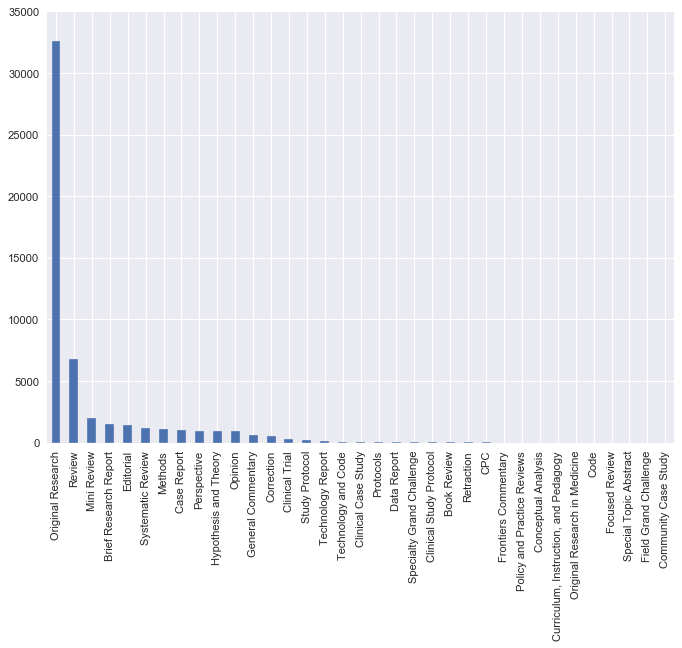

In [38]:
df_describe['article type'].value_counts().plot(kind='bar')

It is also interesting to note that papers with single authors are least common when looking at all the journals collectivley and that the maximum number of authors is the most popular. This could speak to the nature of the publishing system where it could be more advantageous for labs and/or individuals to all appear on a single paper than produce thier own individually.

<AxesSubplot:>

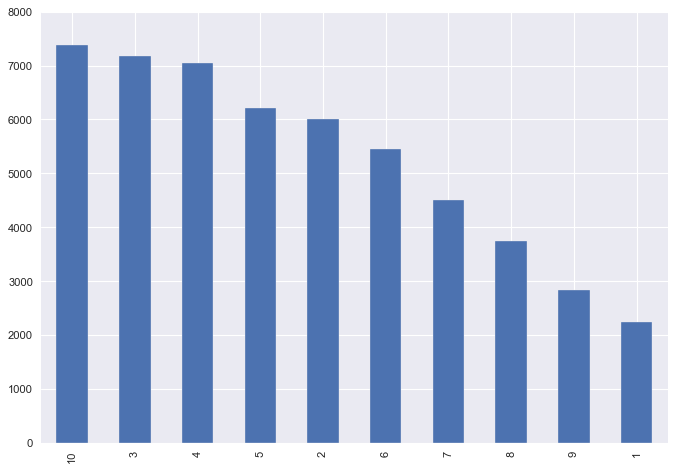

In [37]:
df_describe['article authors'].value_counts().plot(kind='bar')

Of the primary authors, we can see that 16 papers is the maximum for an individual to have published as the primary author and 15 to be quite common. 

In [10]:
df_describe[1].value_counts().head()

Jing Wang           16
Xin Wang            15
Wei Wang            15
Wei Li              15
Grant L. Iverson    15
Name: 1, dtype: int64

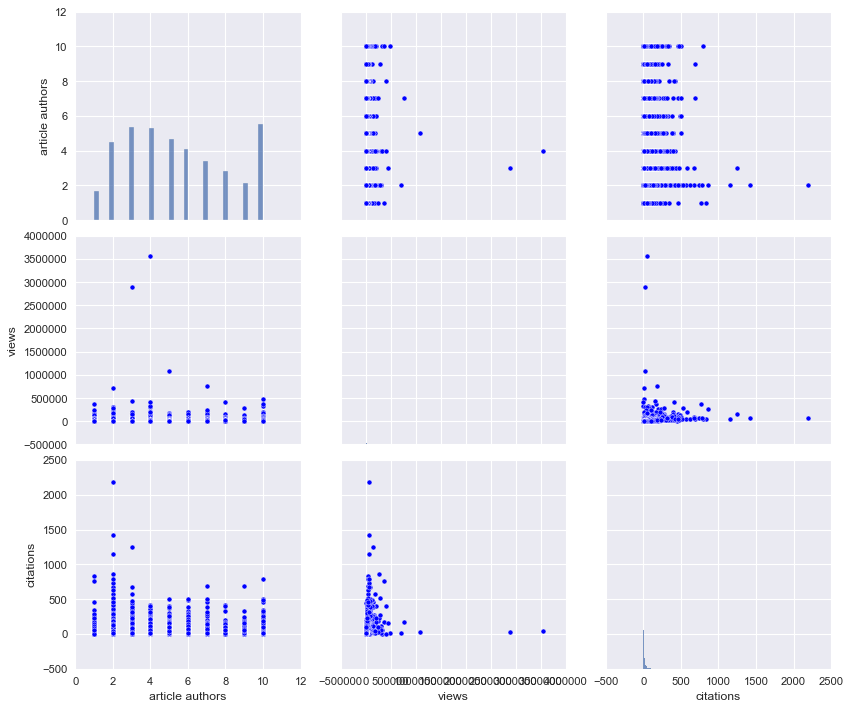

In [46]:
sns.pairplot(df_describe[['article authors','views', 'citations']], height=3, aspect=1.2)

In [49]:
views_citations_corr = df_describe['views'].corr(df_describe['citations'], method="pearson")
#citations_authors_corr = df_describe['citations'].corr(df_describe['article authors'], method="pearson")

#print(views_citations_corr)

In [ ]:
df_handel_nulls.nlargest(n=10, columns=['citations'])

In [ ]:
df_describe['views'].max()

In [ ]:
df_describe['citations'].max()

In [ ]:
df_describe.loc[df_describe['views'] == 3552721.0]

<AxesSubplot:>

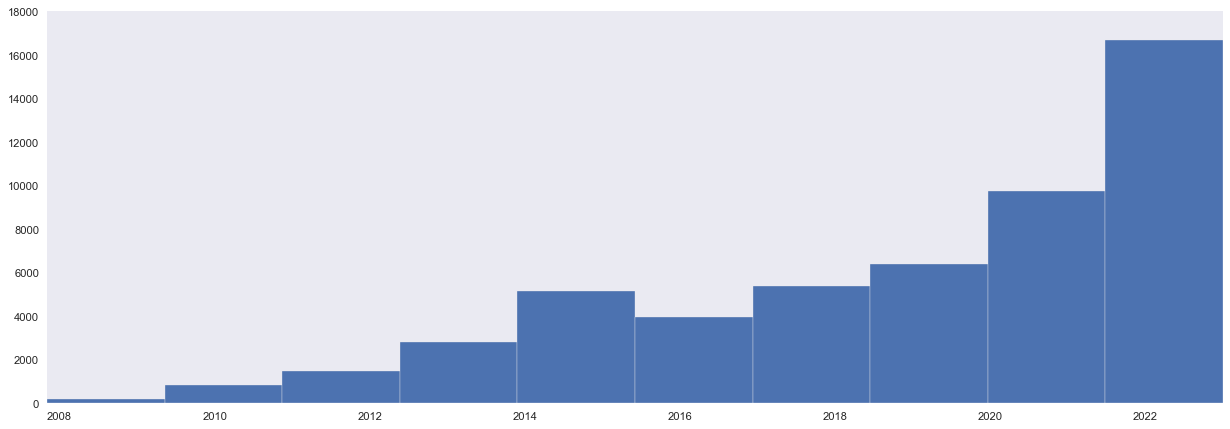

In [47]:
df_describe['article date'].hist(figsize=[15, 5],  grid=False)

## Analysing Hypothesis and Theory Articles
Lets next take a look at the titles of the papers.
sentiment analysis 
most common words

First lets start by analysing all the titles of the hypothesis and theory articles.

In [84]:
df_hypothesis = df_describe.copy()

In [85]:
df_hypothesis = df_hypothesis.loc[df_hypothesis["article type"] == "Hypothesis and Theory"]
display(df_hypothesis)

,Unnamed: 0,article type,article date,article status,article journal,1,2,3,article authors,views,citations,4,5,6,7,8,9,10
5,The optimal calibration hypothesis: how life h...,Hypothesis and Theory,2012-07-05,Published,Frontiers in Evolutionary Neuroscience,David S Chester,Richard S Pond,Stephanie B Richman,4,72541.0,16.0,C. Nathan DeWall,None,None,None,None,None,None
12,Language Development and the Ontogeny of the D...,Hypothesis and Theory,2012-02-06,Published,Frontiers in Evolutionary Neuroscience,Angela Dorkas Friederici,None,None,1,69540.0,44.0,None,None,None,None,None,None,None
17,"Continuity, Divergence, and the Evolution of B...",Hypothesis and Theory,2012-01-03,Published,Frontiers in Evolutionary Neuroscience,James Rilling,Matthew F Glasser,Saad Jbabdi,5,22466.0,103.0,Jesper Andersson,Todd M Preuss,None,None,None,None,None
18,The Evolution of Syntax: An Exaptationist Pers...,Hypothesis and Theory,2011-12-23,Published,Frontiers in Evolutionary Neuroscience,W Tecumseh Fitch,None,None,1,19257.0,41.0,None,None,None,None,None,None,None
49,Control-theoretic integration of stimulation a...,Hypothesis and Theory,2022-11-18,Published,Frontiers in Neuroimaging,Matthew F. Singh,Michael W. Cole,Todd S. Braver,4,256.0,0.0,ShiNung Ching,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52480,Chaotic Desynchronization as the Therapeutic M...,Hypothesis and Theory,2011-06-21,Published,Frontiers in Systems Neuroscience,Charles J Wilson,Bryce Beverlin,Theoden I Netoff,3,11243.0,87.0,None,None,None,None,None,None,None
52491,Estimating Neural Signal Dynamics in the Human...,Hypothesis and Theory,2011-06-06,Published,Frontiers in Systems Neuroscience,Christopher W Tyler,Lora T Likova,None,2,6865.0,3.0,None,None,None,None,None,None,None
52507,Dopaminergic Balance between Reward Maximizati...,Hypothesis and Theory,2011-05-09,Published,Frontiers in Systems Neuroscience,Naama Parush,Naftali Tishby,Hagai Bergman,3,6854.0,26.0,None,None,None,None,None,None,None
52518,The arbitration-extension hypothesis: a hierar...,Hypothesis and Theory,2011-03-11,Published,Frontiers in Systems Neuroscience,Iman Kamali Sarvestani,Mikael Lindahl,Jeanette Hellgren Kotaleski,4,12756.0,17.0,Örjan Ekeberg,None,None,None,None,None,None


<AxesSubplot:>

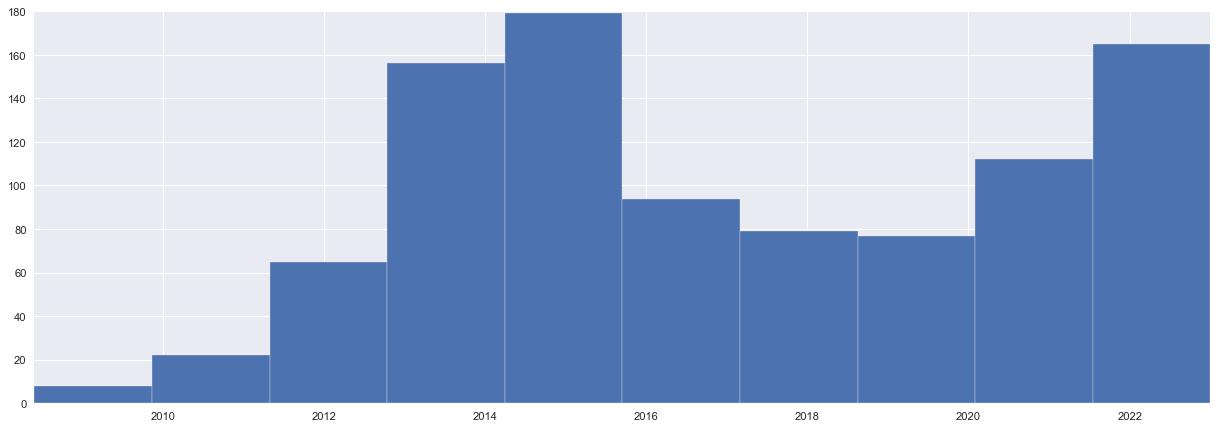

In [86]:
df_hypothesis['article date'].hist(figsize=[15, 5])

Interestingly we see almost the reverese trend in hypothesis and theory articles with fewer authors being much more common. This could also be an indication that the proclivaty of modern research to be done in larger groups makes it harder to produce theoretical work. However this would need to be contrasted against other research types to be more sure.

<AxesSubplot:>

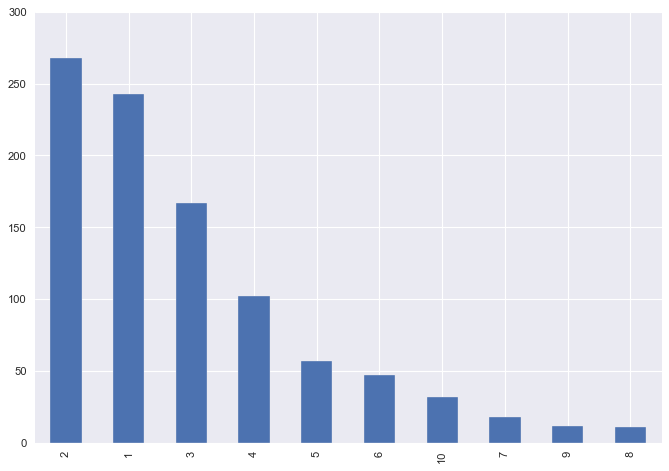

In [87]:
df_hypothesis['article authors'].value_counts().plot(kind='bar')

After importing the dataset it has automatically given it a numerical index but since we want to work with the text data from the article titles we can make that a new column named "article title"

In [94]:
df_hypothesis.rename(columns={'Unnamed: 0':'article title'}, inplace=True)

In [119]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [143]:
titles = df_hypothesis["article title"].to_string()
words = word_tokenize(titles)

def clean_tokens(words):
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if word.isalpha()]
    tokens = [word for word in words if word not in stop_words]
    return tokens

tokens = clean_tokens(words)

vocabulary = set(clean_tokens(words))
print("vocabulary =", len(vocabulary))

vocabulary = 2178


Looking at this frequency distribution would suggest that hypothesis and theories on consciousness are some of the most popular. This is a possible indication that the problem of understanding conciousness is of primary importance for the field of neuroscience.

In [144]:
frequency_dist = nltk.FreqDist(tokens)
frequency_dist.most_common(50)

[('brain', 52),
 ('model', 37),
 ('role', 36),
 ('hypothesis', 31),
 ('neural', 30),
 ('theory', 24),
 ('approach', 21),
 ('cognitive', 20),
 ('potential', 18),
 ('framework', 17),
 ('consciousness', 17),
 ('memory', 16),
 ('neuroscience', 16),
 ('sleep', 15),
 ('cortical', 15),
 ('new', 13),
 ('mechanism', 13),
 ('neuronal', 13),
 ('human', 13),
 ('mechanisms', 13),
 ('computational', 12),
 ('c', 12),
 ('learning', 12),
 ('autism', 12),
 ('understanding', 12),
 ('molecular', 11),
 ('basis', 11),
 ('control', 11),
 ('visual', 11),
 ('motor', 11),
 ('development', 10),
 ('evolution', 10),
 ('time', 10),
 ('active', 10),
 ('modeling', 10),
 ('network', 10),
 ('dynamic', 10),
 ('function', 10),
 ('synaptic', 9),
 ('action', 9),
 ('plasticity', 9),
 ('temporal', 9),
 ('effects', 9),
 ('using', 9),
 ('system', 9),
 ('processing', 9),
 ('dynamics', 9),
 ('attention', 9),
 ('language', 8),
 ('integration', 8)]